In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [29]:
# === RESPLIT CIFAR-10 ===
# load original
(x_train_orig, y_train_orig), (x_test_orig, y_test_orig) = cifar10.load_data()
print("Original shapes:", x_train_orig.shape, y_train_orig.shape, x_test_orig.shape, y_test_orig.shape)

# gabungkan semua (60000)
X = np.concatenate([x_train_orig, x_test_orig], axis=0)
y = np.concatenate([y_train_orig, y_test_orig], axis=0).reshape(-1)

# set proporsi final
train_frac = 0.80
val_frac   = 0.10
test_frac  = 0.10
assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6

# ambil test set akhir dari keseluruhan
X_rest, X_test, y_rest, y_test = train_test_split(
    X, y, test_size=test_frac, random_state=42, shuffle=True, stratify=y)

# bagi sisa jadi train & val
val_frac_rel = val_frac / (train_frac + val_frac)
X_train, X_val, y_train, y_val = train_test_split(
    X_rest, y_rest, test_size=val_frac_rel, random_state=42, shuffle=True, stratify=y_rest)

# normalisasi
X_train = X_train.astype("float32") / 255.0
X_val   = X_val.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0

print("Final splits:")
print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)

Original shapes: (50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)
Final splits:
Train: (48000, 32, 32, 3) (48000,)
Val  : (6000, 32, 32, 3) (6000,)
Test : (6000, 32, 32, 3) (6000,)


In [4]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
], name="augmentation")

In [12]:
num_classes = 10
input_shape = (32, 32, 3)

model = keras.Sequential([
    keras.Input(shape=input_shape),

    data_augmentation,

    # Block 1
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization_6 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 64)       

In [ ]:
# learning rate rendah + scheduler
initial_lr = 1e-3
optimizer = keras.optimizers.Adam(learning_rate=initial_lr)

# cosine decay:
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_lr,
    first_decay_steps=2000, # adjust by steps; ok for moderate epochs
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [15]:
# callbacks: checkpoint, earlystop, reduceLR (redundant dengan schedule but ok)
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=12, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=80,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/80
1500/1500 [==============================] - 184s 120ms/step - loss: 1.6939 - accuracy: 0.4104 - val_loss: 1.1857 - val_accuracy: 0.5835 - lr: 1.4700e-04
Epoch 2/80
1500/1500 [==============================] - 163s 109ms/step - loss: 1.2934 - accuracy: 0.5406 - val_loss: 1.7745 - val_accuracy: 0.4577 - lr: 8.5383e-04
Epoch 3/80
1500/1500 [==============================] - 171s 114ms/step - loss: 1.0680 - accuracy: 0.6260 - val_loss: 0.8323 - val_accuracy: 0.7118 - lr: 3.0902e-04
Epoch 4/80
1500/1500 [==============================] - 161s 108ms/step - loss: 0.8802 - accuracy: 0.6951 - val_loss: 0.7532 - val_accuracy: 0.7353 - lr: 1.4901e-10
Epoch 5/80
1500/1500 [==============================] - 161s 107ms/step - loss: 0.9903 - accuracy: 0.6556 - val_loss: 0.8324 - val_accuracy: 0.7097 - lr: 9.1584e-04
Epoch 6/80
1500/1500 [==============================] - 161s 107ms/step - loss: 0.8670 - accuracy: 0.6999 - val_loss: 0.7677 - val_accuracy: 0.7360 - lr: 6.9152e-04
Epoch 7/80

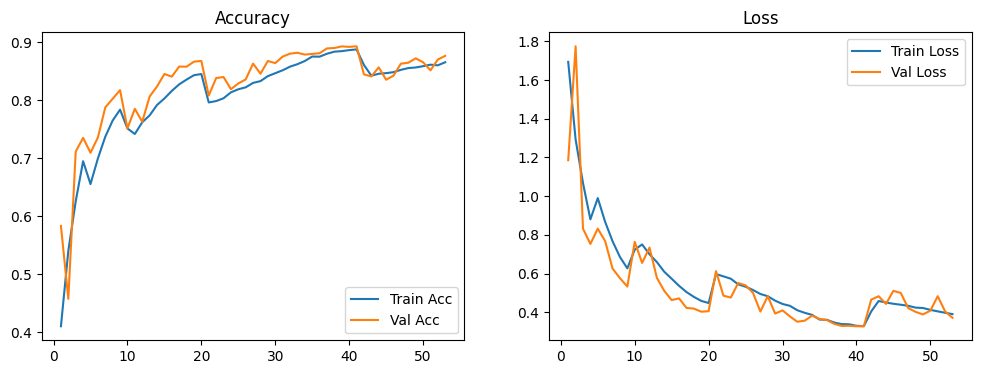

In [32]:
def plot_history(h):
    acc = h.history["accuracy"]
    val_acc = h.history["val_accuracy"]
    loss = h.history["loss"]
    val_loss = h.history["val_loss"]
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, label="Train Acc")
    plt.plot(epochs, val_acc, label="Val Acc")
    plt.legend()
    plt.title("Accuracy")

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Val Loss")
    plt.legend()
    plt.title("Loss")

    plt.show()

plot_history(history)

In [31]:
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy : {test_acc*100:.2f}%")

Train Accuracy: 93.52%
Test Accuracy : 88.45%


In [18]:
model.save("submission/saved_model")
print("SavedModel exported → submission/saved_model/")

INFO:tensorflow:Assets written to: submission/saved_model\assets


INFO:tensorflow:Assets written to: submission/saved_model\assets


SavedModel exported → submission/saved_model/


In [21]:
import os
os.makedirs("submission/tflite", exist_ok=True)

# Convert TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()
open("submission/tflite/model.tflite", "wb").write(tflite_model)

# Save labels
labels = [
    "airplane","automobile","bird","cat","deer",
    "dog","frog","horse","ship","truck"
]

with open("submission/tflite/label.txt", "w") as f:
    f.write("\n".join(labels))

print("TFLite + label.txt created!")

TFLite + label.txt created!


1/1 [==============================] - 0s 107ms/step
Label asli      : dog
Prediksi model : dog


(-0.5, 31.5, 31.5, -0.5)

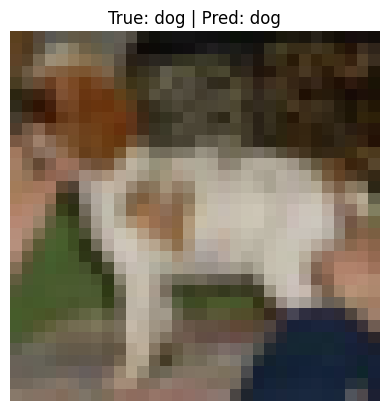

In [33]:
# Load SavedModel
model = tf.keras.models.load_model("submission/saved_model")

# Load CIFAR-10 sample
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Ambil 1 gambar dari test set
index = 12  # kamu bisa ganti ke angka berapa saja
img = X_test[index]
label = y_test[index][0]

# Preprocess
img_resized = img / 255.0
img_input = np.expand_dims(img_resized, axis=0)

# Predict
pred = model.predict(img_input)
pred_class = pred.argmax()

# Mapping label CIFAR-10
classes = ["airplane","automobile","bird","cat","deer",
           "dog","frog","horse","ship","truck"]

print("Label asli      :", classes[label])
print("Prediksi model :", classes[pred_class])

# Tampilkan gambar
plt.imshow(img)
plt.title(f"True: {classes[label]} | Pred: {classes[pred_class]}")
plt.axis("off")